# Project 1

## Exploratory data analysis and preprocessing

The **exploratory data analysis** is the statistical treatment to which the samples collected during a research process in any scientific field are subjected.
For greater speed and accuracy, the entire process is usually carried out by computer, with specific applications for statistical treatment.

### Application to Data Mining

In **data mining**, although not mandatory, it is a good practice to analyze the data you will be working with in order to observe its main characteristics in order to get an idea of the structure of the data set, and identify the target variable and possible modeling techniques.

**Basic Process**
- *Transform the data*: It helps us know what to do with null, missing values, or atypical data. In addition, it establishes if there is a need to reduce the dimensionality of data.
- *Visualize*: Use some tool to make a graphical representation of the data, for example, R, Jupyter notebook, Google Colab, etc.
- *Analyze and interpret*: Analyze and interpret the data through different visualizations.
- *Document*: Document all the graphs and statistics generated.

This process is also helpful when reviewing the data description to understand the meaning of each characteristic.

There are several activities in doing an exploratory data analysis but in terms of data mining the key points to be made are:

- Description of the data structure.
- Identification of missing data.
- Detection of outliers.
- Identification of relationships between variable pairs.

The **goal of this project** is to learn how to do data exploration. In this case, data from **New York City Yellow Taxis** is used.

At the end of the notebook, you should be able to answer the following question:


## How has covid affected the use of taxis in New York?

Some of the questions you will ask yourselves throughout the notebook are:
- How has covid changed the use of taxis in NYC?
- What pick-up distribution do the taxis follow and what distance / duration do they take?
- What are the areas where taxis are picked up the least? And where else do people go?
- What are the most usual times?
- Which days of the week and month are used the most? Possible reasons?

**Install and import the required libraries**

In [1]:
! pip install pyarrow
! pip install pyshp
! pip install shapely
! pip install descartes

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [3]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Global variables

YEARS = [2019, 2020, 2021]

First of all, you need to download the data:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [5]:
# Download the Trip Record Data
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'):
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)): 
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')

  0%|          | 0/3 [00:00<?, ?it/s]

## 01. Data cleaning

In order to have clean and useful data, it is necessary to delete all those rows that contain corrupt information:
- The pick-up is after the drop-off.
- Dates are imported by months and years. Are the dates correct?
- Traveling with zero passengers?
- Do you travel very long or particularly short?
- Negative payments.

**Data Dictionary**

Only the next columns are needed:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged. 
- *Passenger_count*: The number of passengers in the vehicle. (This is a driver-entered value)
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip. 
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers. Does not include cash tips.

**Remarks:**

- To speed up the calculations and reduce the computation time, do a uniform sampling of the data (a sample out of 1000).
- Datetime columns are *to_datetime* series (help to search functions)

In [6]:
def load_table(year, month):
    """
    Function that reads the downloaded data and converts it to a DataFrame
    """
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()

In [7]:
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 
                 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

def clean_data(data, year, month, sampling=1000):
    """
    Function that clears the month data.
    """
    # Sampling data to speed up calculations
    data = data[::sampling]
    # Filtering data by required columns only
    data = data[required_data]
    # Filtering out trips where the dropoff time is higher than the pickup time
    data = data[data.tpep_pickup_datetime < data.tpep_dropoff_datetime]
    # Filtering by trips with at least one passenger
    data = data[data.passenger_count > 0]   
    # Dropping rows with NaN values
    data = data[np.logical_not(np.isnan(data.passenger_count))]
    
    data['year'] = year
    
    return data
    

In the ***post_processing*** function you can add all information you need in order to perform the necessary exploration.

In [8]:
import datetime as dt

def post_processing(data):
    """
    Function to implement any type of post-processing required.
    """
    #We convert our trip distance from miles to km
    data['trip_distance'] = data.trip_distance*1.609344
    #We split the pickup/dropoff date/time
    data['pickup_day'] = data.tpep_pickup_datetime.dt.dayofweek
    data['pickup_month'] = data.tpep_pickup_datetime.dt.month
    data['pickup_year'] = data.tpep_pickup_datetime.dt.year
    data['pickup_hour'] = data.tpep_pickup_datetime.dt.hour
    data['pickup_week'] = data.tpep_pickup_datetime.dt.isocalendar().week
    data['pickup_dayofyear'] = data.tpep_pickup_datetime.dt.dayofyear
    
    
    data['dropoff_day'] = data.tpep_dropoff_datetime.dt.dayofweek
    data['dropoff_month'] = data.tpep_dropoff_datetime.dt.month
    data['dropoff_year'] = data.tpep_dropoff_datetime.dt.year
    data['dropoff_hour'] = data.tpep_dropoff_datetime.dt.hour
    data['dropoff_week'] = data.tpep_dropoff_datetime.dt.isocalendar().week
    data['dropoff_dayofyear'] = data.tpep_dropoff_datetime.dt.dayofyear
    #We calculate the time differencet between the pickup and droppoff in hours
    temp_col = data.tpep_dropoff_datetime - data.tpep_pickup_datetime
    data['trip_duration'] = [x.total_seconds()/3600 for x in temp_col]
    #We calculate the average speed for each trip
    data['trip_avg_speed'] = data.trip_distance/data.trip_duration
    
    #We clean some more values
    #We get rid off the trips where the speed is higher than 120 km/h 
    #data = data[data['trip_avg_speed'] > 120]
    
    
    
    
    return data
    
    
    # HERE YOUR CODE
    #raise NotImplementedError

Create a new dataset that contains all the information for the years: 2019, 2020, and 2021.

Remember that in order to reduce the memory required, you can take a subsample of the data.

In [9]:
df = pd.concat([clean_data(load_table(year, month), year, month) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave = False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [10]:
import datetime as dt
df = post_processing(df)
df.head(2)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_week,pickup_dayofyear,dropoff_day,dropoff_month,dropoff_year,dropoff_hour,dropoff_week,dropoff_dayofyear,trip_duration,trip_avg_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.414016,151,239,1,7.0,9.95,2019,...,1,1,1,1,2019,0,1,1,0.111111,21.726144
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,3.073847,148,137,2,8.5,9.80,2019,...,1,1,1,1,2019,1,1,1,0.135278,22.722483


In [11]:
# Cutting variables by 2 standard deviations from the mean
trip_distance_cut = df['trip_distance'].mean() + (df['trip_distance'].std() * 2)
fare_amount_cut = df['fare_amount'].mean() + (df['fare_amount'].std() * 2)
trip_duration_cut = df['trip_duration'].mean() + (df['trip_duration'].std() * 2)

In [12]:
# Remove outliers
    
df_filtered = df[(df['trip_distance'] > 0 & (df['trip_distance'] <= trip_distance_cut)) & 
                 (df['fare_amount'] >= 3 & (df['fare_amount'] <= fare_amount_cut)) &
                 (df['trip_duration'] > 1 & (df['trip_duration'] <= trip_duration_cut))]

In [13]:
df_filtered.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_week,pickup_dayofyear,dropoff_day,dropoff_month,dropoff_year,dropoff_hour,dropoff_week,dropoff_dayofyear,trip_duration,trip_avg_speed
11000,2019-01-01 00:48:17,2019-01-02 00:06:00,2.0,2.092147,90,246,1,7.5,11.44,2019,...,1,1,2,1,2019,0,1,2,23.295278,0.089810
115000,2019-01-01 14:07:18,2019-01-01 15:38:01,5.0,38.833471,132,223,2,52.0,58.56,2019,...,1,1,1,1,2019,15,1,1,1.511944,25.684456
293000,2019-01-02 15:59:32,2019-01-02 17:07:37,1.0,16.576243,107,35,1,45.5,46.30,2019,...,1,2,2,1,2019,17,1,2,1.134722,14.608195
318000,2019-01-02 17:20:58,2019-01-02 18:21:09,1.0,19.199474,137,26,2,43.5,45.30,2019,...,1,2,2,1,2019,18,1,2,1.003056,19.140988
479000,2019-01-03 13:55:24,2019-01-03 15:04:40,1.0,34.874484,132,75,2,52.0,58.56,2019,...,1,3,3,1,2019,15,1,3,1.154444,30.208889


## 02. Visualizations (by years)

### Number of trips by year

Can you answer the question: **Has covid increased / decreased the number of trips made by taxis?**

To answer this question, create a bar figure showing the number of trips per year.

In [14]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    A function that creates a bar figure from the dataframe *df* and the content of the *column* that contains the information.
    """
    
    # Let's create the bar chart counting diferent counts depending on the values from the column 
    x,y = np.unique(df[column],return_counts = True)
    plt.bar(x,y)
    
    # Add labels and titles to the chart
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    # Decide the unique values we will use in the x-axis
    plt.xticks(YEARS)
    
    return
    
    # HERE YOUR CODE
    #raise NotImplementedError

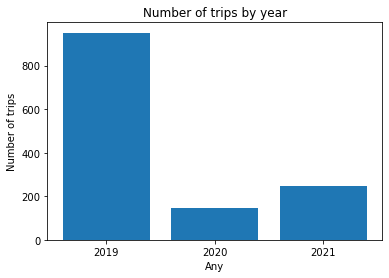

In [15]:
bar_plot(df_filtered, 'year', 'Any', 'Number of trips', 'Number of trips by year')

**Question: Is this the behavior you expected? Why?**

> ANSWER

Yes, the behaivour is the expected one. It makes sense that this would be the behaivor since because the 2020s lockdowns there was less movement in the cities hence less trip's numbers. 

Now, you will visualize **how many passengers there are per taxi and per year**.

Create a figure with three subplots (one per year) where can be seen the number of passengers per year.

Then repeat the same chart viewing the % (use the *norm* parameter).

In [16]:
def passengers_taxi(df, norm = False):
    """
    Function that displays how many passengers there are per taxi and per year
    """
    # Set up the subplot figure (1 row, 3 columns)
    fig = plt.figure(figsize=(20, 10))
    axes = [
        fig.add_subplot(131), # (1 row, 3 columns, position 1)
        fig.add_subplot(132), # (1 row, 3 columns, position 2)
        fig.add_subplot(133)  # (1 row, 3 columns, position 3)
    ]
   
    # For each year (and axes) make subplot
    for year, ax in zip(YEARS, axes):
        # Subset df to plot
        plot_df = df[df["year"]==year]["passenger_count"]
        # If normed...
        if norm:
            # Define normed plot label names
            x_label_name = 'Passengers per taxi'
            y_label_name = 'Distribution [%]'
            # Add weights to normalize
            weights = np.ones_like(plot_df)/float(len(plot_df))*100
            ax.hist(plot_df, weights=weights)
        # If not normed...
        else:
            # Define non-normed plot label names
            x_label_name = 'Passengers per taxi'
            y_label_name = 'Count'
            # Plot simple histogram
            ax.hist(plot_df)

        # Add title, axes names and limit for x axes
        ax.set_title(f"Histogram for {year}")
        ax.set_xlabel(x_label_name)
        ax.set_ylabel(y_label_name)
        ax.set_xlim((0, 7))
   
    plt.show()
    
    return

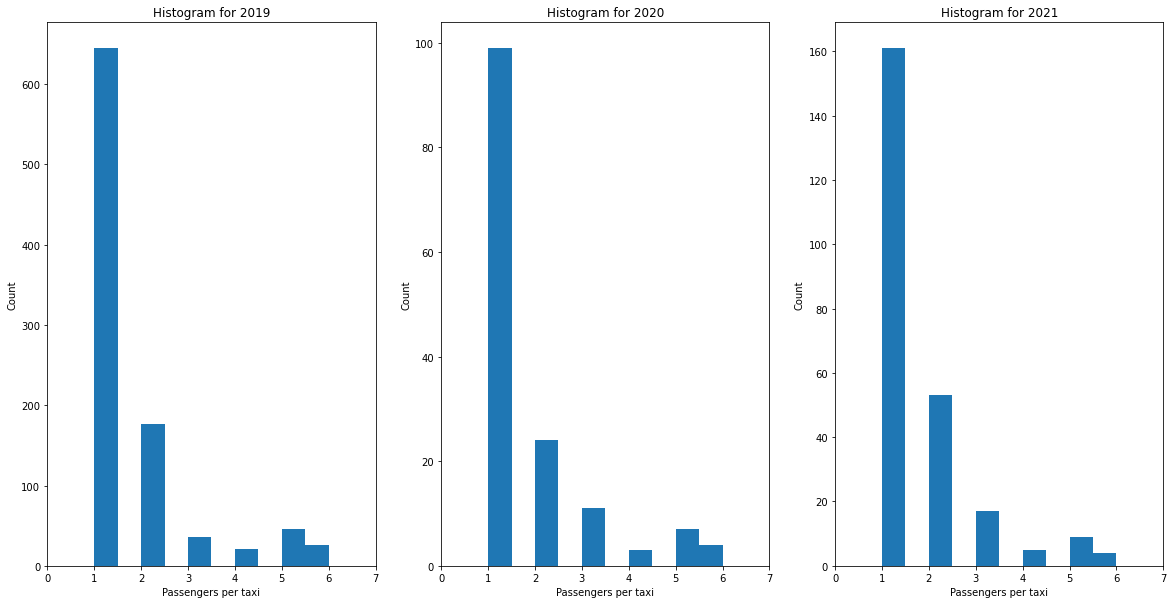

In [17]:
passengers_taxi(df_filtered)

In [18]:
def passengers_taxi(df, norm = True):
    """
    Function that displays how many passengers there are per taxi and per year
    """
    # Set up the subplot figure (1 row, 3 columns)
    fig = plt.figure(figsize=(20, 10))
    axes = [
        fig.add_subplot(131), # (1 row, 3 columns, position 1)
        fig.add_subplot(132), # (1 row, 3 columns, position 2)
        fig.add_subplot(133)  # (1 row, 3 columns, position 3)
    ]
   
    # For each year (and axes) make subplot
    for year, ax in zip(YEARS, axes):
        # Subset df to plot
        plot_df = df_filtered[df_filtered["year"]==year]["passenger_count"]
        # If normed...
        if norm:
            # Define normed plot label names
            x_label_name = 'Passengers per taxi'
            y_label_name = 'Distribution [%]'
            # Add weights to normalize
            weights = np.ones_like(plot_df)/float(len(plot_df))*100
            ax.hist(plot_df, weights=weights)
        # If not normed...
        else:
            # Define non-normed plot label names
            x_label_name = 'Passengers per taxi'
            y_label_name = 'Count'
            # Plot simple histogram
            ax.hist(plot_df)

        # Add title, axes names and limit for x axes
        ax.set_title(f"Histogram for {year}")
        ax.set_xlabel(x_label_name)
        ax.set_ylabel(y_label_name)
        ax.set_xlim((0, 7))
   
    plt.show()
    
    return

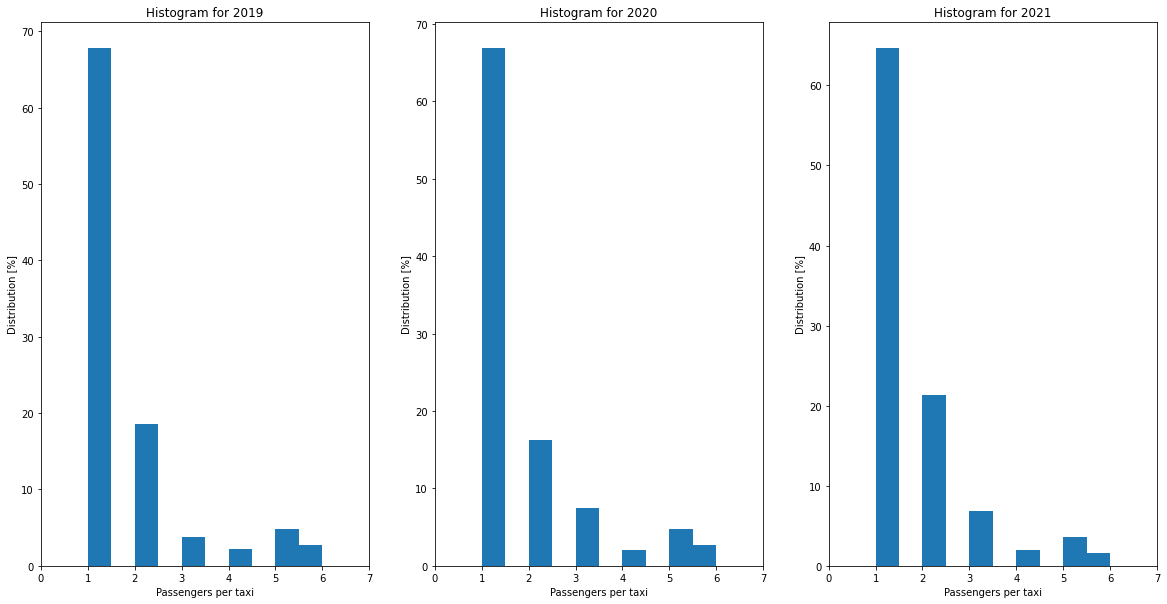

In [19]:
passengers_taxi(df_filtered)

In the previous figure, you have visualized each year separately. To make the visualization easier to interpret, combine all the information into a graph.

The expected visualization has to contain three columns (different colors) for each number of passengers.

Then repeat the same chart viewing the % (use the *norm* parameter).

In [20]:
def passengers_taxi_year(df, x, hue, xlabel, ylabel, title):
    """
    Function that displays how many passengers there are per taxi and per year
    """    
    # Creating the count plot and grouping by column
    sns.countplot(data=df, x=x, hue=hue, palette='Blues')
    
    # Adding labels to the axes and a title to the plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    # Displaying plot
    plt.show()
    
    return

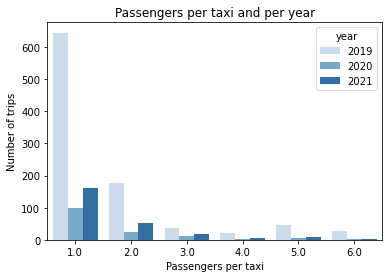

In [21]:
passengers_taxi_year(df_filtered, 'passenger_count', 'year', 'Passengers per taxi', 'Number of trips', 'Passengers per taxi and per year')

**Question: What impact have you seen on the data? Do you think covid had a lot of impact?**

> ANSWER

Although there is a clear impact on the absolute number of passengers per taxi due to COVID, mostly in 2020, it did not impact the distribution of passengers per taxi – same observation even when the data is normalized.

## 03. Number of trips

So far, you have seen the number of trips there have been in the years studied.

Let's study what changes can be seen if you aggregate the data by hours, days of the week, week of the year, and months.


These visualizations have to be done for the *pick-up* and *drop-off* columns. 

Furthermore, the information has to be split by year and represented with dashed lines, and marked with a round or cross wherever the value is.

In [22]:
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Function that visualizes the number of trips by different data aggregations
    """
    
    # We get the value for the two columns we expect
    
    col0 = columns[0]
    col1 = columns[1]
    
    # We create the figure for the plots
    
    plt.figure(figsize =(10,10))
    
    for year in YEARS:
        
        # We filter the date for each column and year

        counts0 = df.loc[df.year == year,col0].value_counts().sort_index()
        counts1 = df.loc[df.year == year, col1].value_counts().sort_index()
        
        # We create both subplots one for each column and year
        
        plt.subplot(211)
        plt.plot(counts0.index,counts0.values,linestyle = 'dashed', marker = 'o')
        plt.legend(YEARS)
        
        plt.subplot(212)
        plt.plot(counts1.index,counts1.values, linestyle = 'dashed', marker = 'o')
        plt.legend(YEARS) 
        
    #We add labels to each axis and a title to the plot
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    return
    
    # HERE YOUR CODE
    #raise NotImplementedError
    
    

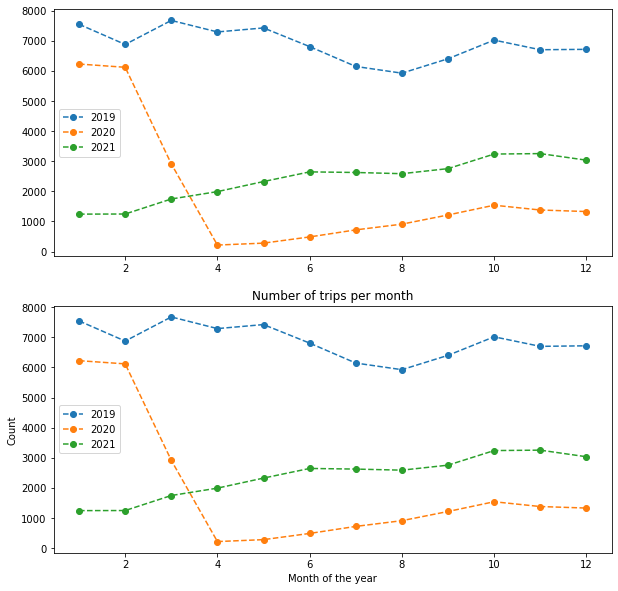

In [23]:
visualize_trips(df, ['pickup_month', 'dropoff_month'], title = 'Number of trips per month', xlabel = 'Month of the year', ylabel = 'Count')

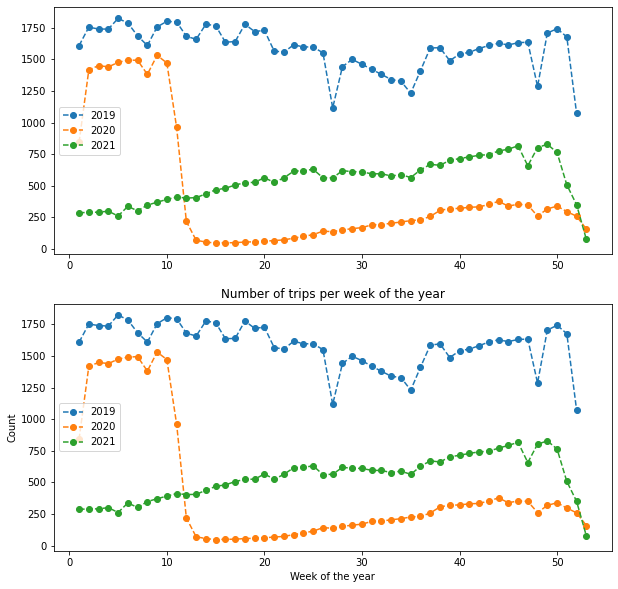

In [24]:
visualize_trips(df, ['pickup_week', 'dropoff_week'], title = 'Number of trips per week of the year', xlabel = 'Week of the year', ylabel = 'Count')

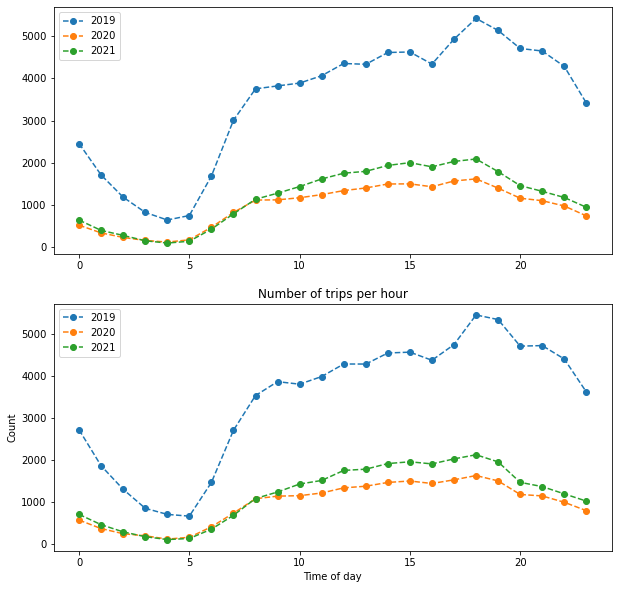

In [25]:
visualize_trips(df, ['pickup_hour', 'dropoff_hour'], title = 'Number of trips per hour', xlabel = 'Time of day', ylabel = 'Count')

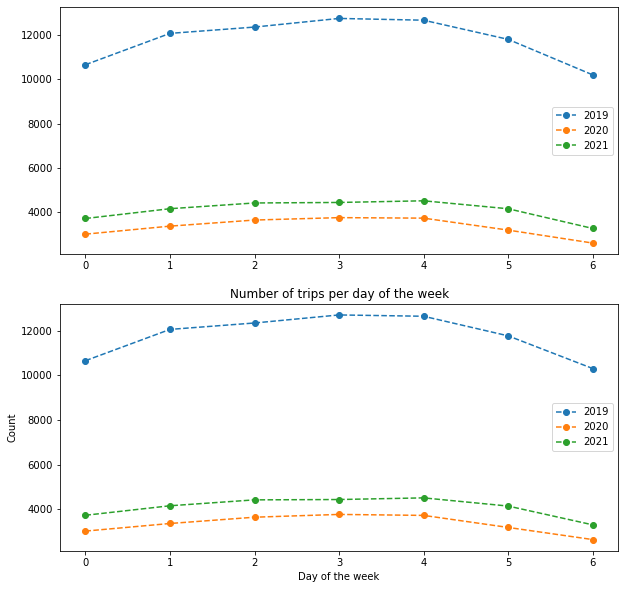

In [26]:
visualize_trips(df, ['pickup_day', 'dropoff_day'], title = 'Number of trips per day of the week', xlabel = 'Day of the week', ylabel = 'Count')

**Question: What behaviors do you see in each case? What do you think is the reason?**

> ANSWER

We can see a huge difference in the amound of trips for all the columns we are showing. Particularlly, there was a huge drop in the monthly trips between the 2nd and the 4th month from 2020 comparing with the same period of 2019. From then the number of trips is slowly recovering.

## 04. Distance/duration and speed relationship

In the data, there is the distance traveled by taxis on each trip. Furthermore, you can extract the duration of the trips using: *tpep_dropoff_datetime* and *tpep_pickup_datetime*.

Now, you will find out how covid affected the distances and durations of journeys along with the speed of taxis.

Do you think the traffic density changed?

### Histograms

Visualize the **histograms** of distance and duration per year.

You can use *plt.hist()* or *plt.bar()* function.

In [27]:
test = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
test.head(1000).mean()

Timedelta('0 days 00:15:16.960000')

In [28]:
def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    """
    Function that creates a histogram from the information contained in the column *column* of the dataframe *df*
    """
    
    # We create a list where we will store all the data we need split by year
    
    hist_data = []
    
    for year in YEARS:
        
        #We get the data from each year for the corresponding column
    
        temp_df = df[df.year == year]
        temp_column = temp_df[column]
        hist_data.append(temp_column)
    
    # We determine the size from the figure and create the hist
    
    plt.figure(figsize = (20,5))
    plt.hist(hist_data)
    
    # We add all the extra information to the plot
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.legend(YEARS)
    plt.show()
    
    return
    # HERE YOUR CODE
    #raise NotImplementedError

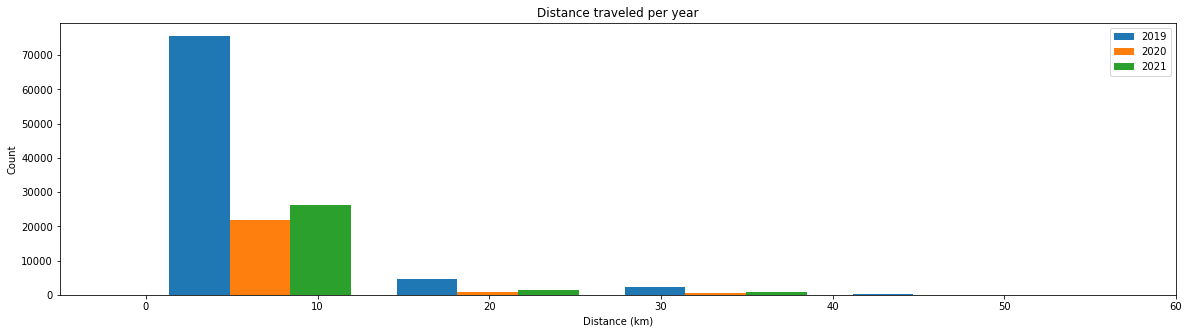

In [29]:
visualize_histograms(df, 'trip_distance', title = 'Distance traveled per year', 
                     xlabel = 'Distance (km)', ylabel = 'Count', xlim = (-5, 60))

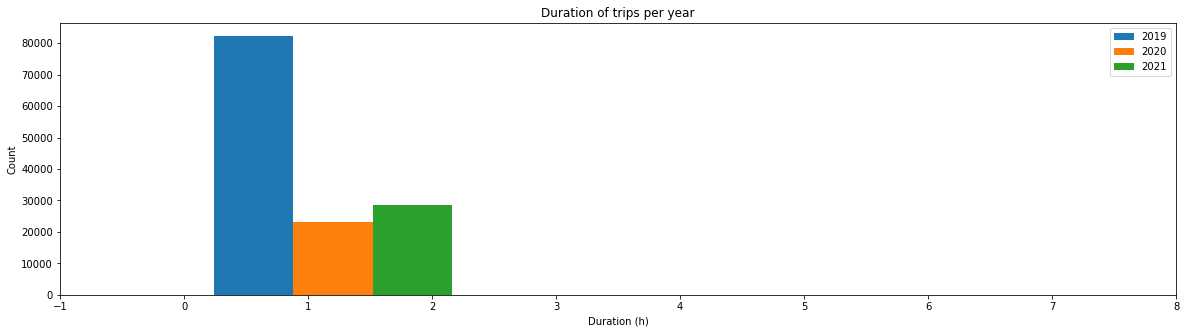

In [30]:
visualize_histograms(df, 'trip_duration', title = 'Duration of trips per year', 
                     xlabel = 'Duration (h)', ylabel = 'Count', xlim = (-1, 8) )


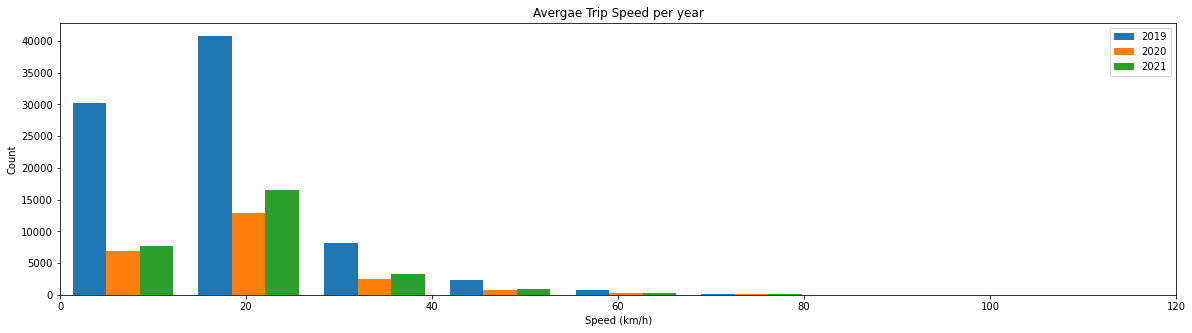

In [31]:
#We extra filter the data to get a more useful chart
df_filtered = df[df['trip_avg_speed']<=150]

visualize_histograms(df_filtered, 'trip_avg_speed', title = 'Avergae Trip Speed per year', 
                     xlabel = 'Speed (km/h)', ylabel = 'Count', xlim = (0, 120) )


**QUESTIONS:**

* How do you think covid affected travel distances and durations?

* And the speed of taxis?

> ANSWER

The distribution does differ that much from year to year. We can see as the taller column is always the same for all three years. It doesn't seem covid affected that much any of the columns we are visualizazing.

### Scatter plot and correlation

Create scatter plots to illustrate the relationship between trip duration and distance.

It is possible that the data contain samples outside the distribution (outliers). In this case, skip this samples and display the figure again.

To see if any correlation exists, it is interesting to use the *sns.regplot()* function.

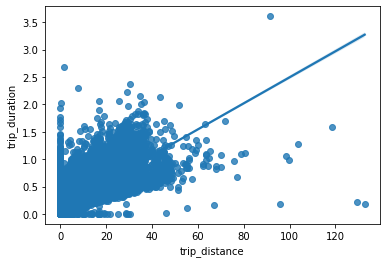

In [32]:
import seaborn as sns
x_value = 'trip_distance'
y_value = 'trip_duration'
new_df = df[df[y_value]<4]
sns.regplot(x = x_value, y = y_value, data = new_df)



plt.show()

In [33]:
import seaborn as sns

def scatter_plot(df, x_value, y_value, xlabel, ylabel, remove_outliers = False):
    """
    Function that displays a scatter plot given the name of the columns that contains the information
    """
    if remove_outliers == False:
        sns.regplot(x = x_value, y = y_value, data = df, marker = 'x')
        
    else:
        # We remove the trips that are has a too short or long duration
        new_df = df[df[y_value]<4]
        new_df = new_df[new_df[y_value]>(1/60)] #longer than 1 minute
        
        new_df = new_df[new_df[x_value]<80]
        new_df = new_df[new_df[x_value]>0]
        
        sns.regplot(x = x_value, y = y_value, data = new_df, marker = 'x')
        
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
    return

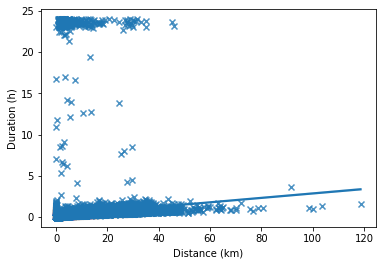

In [34]:
scatter_plot(df_filtered, 'trip_distance', 'trip_duration', 'Distance (km)', 'Duration (h)')
# we can see as there are many outliers and the chart doesn't give us much information

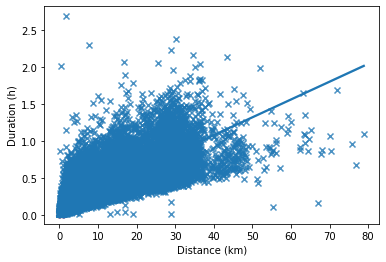

In [35]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distance (km)', 'Duration (h)', True)

> ANSWER

We can say that once we remove the outliers, the final result follows in some way a correlation towards the plot line. So we can conclude there exist a correlation between both variables once we delete the outliers.

As you did in section 3, visualize the time and distance data for the weeks and months of the year.

In [36]:
columns = ['pickup_week', 'dropoff_week']

column_data = 'trip_distance'




In [37]:
def visualize_per_period(df, column_data, columns, xlabel, ylabel, title):
    """
    Function that show the distance / duration of trips in the time determined
    """
    col0=columns[0]
    col1=columns[1]

    means0 = pd.DataFrame(df_filtered.groupby(['year',col0])[column_data].mean().reset_index())
    means1 = pd.DataFrame(df_filtered.groupby(['year',col1])[column_data].mean().reset_index())

    plt.figure(figsize =(10,10))

    for year in YEARS:

        # We filter the date for each column and year

        means0_y = means0[means0['year'] == year]
        means1_y = means1[means1['year'] == year]

        # We create both subplots one for each column and year

        plt.subplot(211)
        plt.plot(means0_y[col0],means0_y[column_data],linestyle = 'dashed', marker = 'x')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title + " ("+str(col0)+")")
        plt.legend(YEARS) 

        plt.subplot(212)
        plt.plot(means1_y[col1],means1_y[column_data],linestyle = 'dashed', marker = 'x')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title + " ("+str(col1)+")")
        plt.legend(YEARS) 

    #We add labels to each axis and a title to the plot

    
    plt.show()
    return
    # HERE YOUR CODE
    #raise NotImplementedError

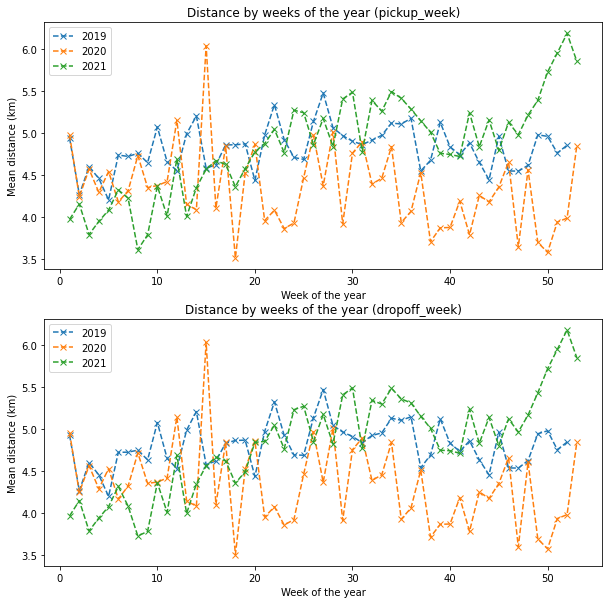

In [38]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_week', 'dropoff_week'],
                    xlabel = 'Week of the year', ylabel = 'Mean distance (km)', title = 'Distance by weeks of the year')

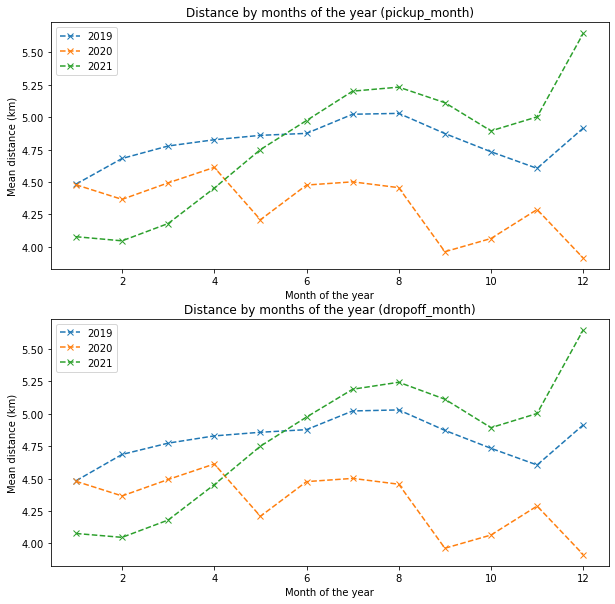

In [39]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Month of the year', ylabel = 'Mean distance (km)', title = 'Distance by months of the year')

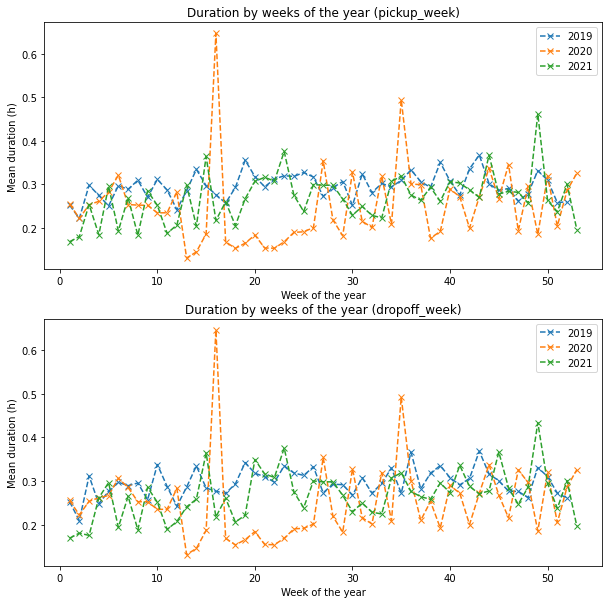

In [40]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_week', 'dropoff_week'],
                     xlabel = 'Week of the year', ylabel = 'Mean duration (h)', title = 'Duration by weeks of the year')

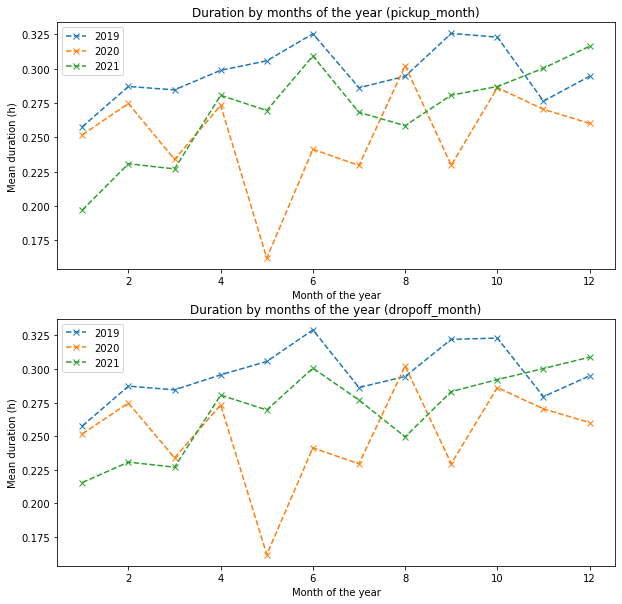

In [41]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Month of the year', ylabel = 'Mean duration (h)', title = 'Duration by months of the year')

**Question: Is there any strange behavior apart from covid? What can it be caused by?**

There is a strange behaivour around the 16th week (around the middle of april) where the mean distance increases sharply and as well as the duration. After these week the taxi usage decreases to abnormal levels. This is probably caused for the worst moments of the pandemic.

As far as the data the charts show there isnt much difference between the duration, distance and speed between the years of study

So far, you have shown the data by aggregating different information.

Now, you have to visualize the data like images. For that, you will use the *plt.imshow()* function which displays images and arrays.

Implement a function that displays heatmaps by year (each function display 3 heatmaps, one per year):

- a heatmap showing what time of day are the longest trips during the year.
- a heatmap showing what time of day are the longest trips during the week.

In [42]:
def heatmap(df, group, column_data, xlabel, ylabel, columns = None):
    """
    Function that aggregates data appropriately to display a heatmap
    """
    
    
    plt.figure(figsize = (25,15))
    
    n = 311
    for year in YEARS:
        
        df_y = df[df.year == year]
        values = df_y.groupby(group).mean()[column_data].unstack().fillna(0)

        values /= values.max() # is used to normalize the data
        

        plt.subplot(n)
        plt.title('Data from the year: ' + str(year))
        plt.imshow(values)
        plt.colorbar()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        n=n+1
        
        #if columns != None:
         #   plt.xticks(columns)
                
        
    plt.show()
    return
    # HERE YOUR CODE
    #raise NotImplementedError

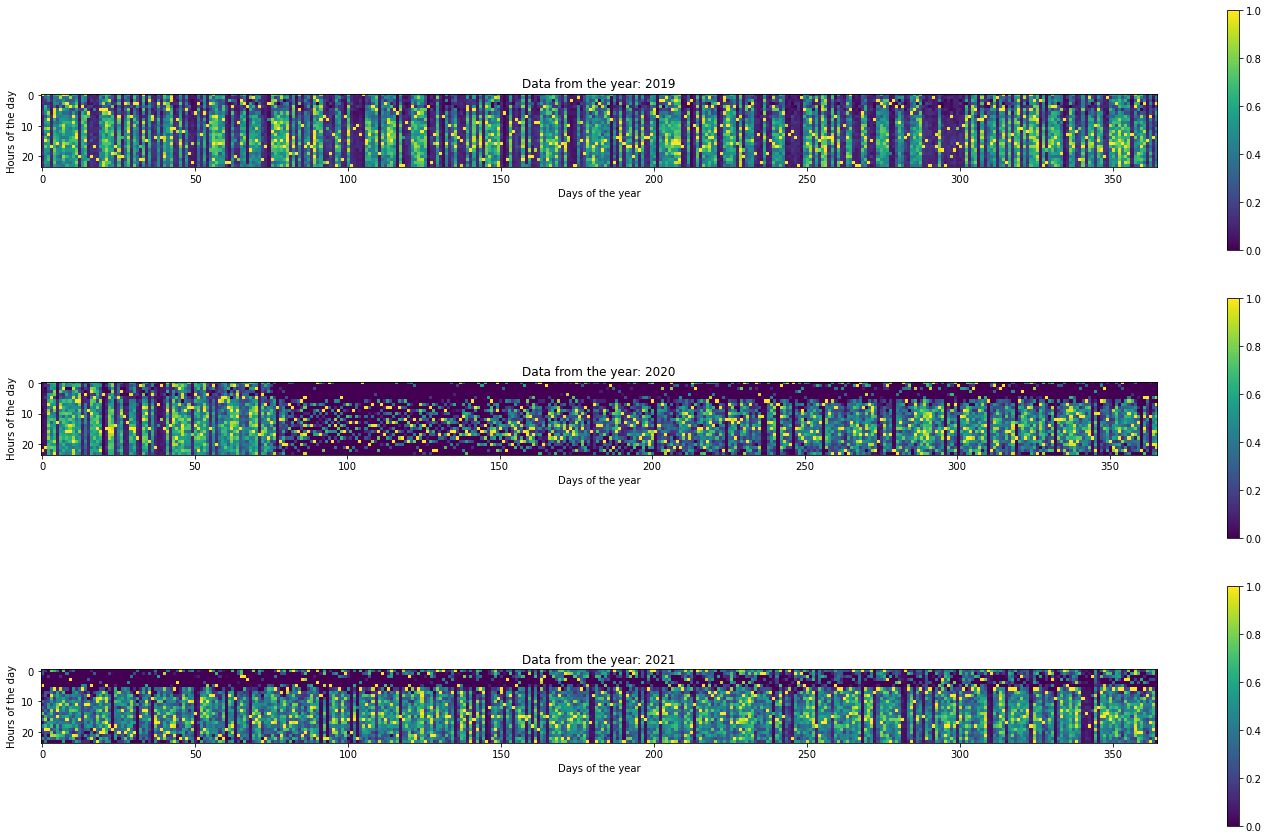

In [43]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_duration', 'Days of the year', 'Hours of the day')

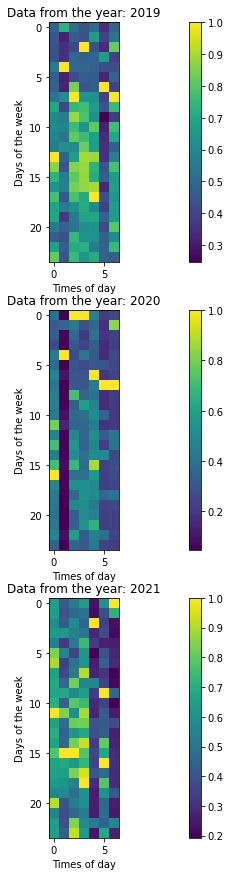

In [44]:
heatmap(df, ['pickup_hour','pickup_day'], 'trip_duration', 'Times of day', 'Days of the week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Repeat the previous heatmaps visualizing the distance.

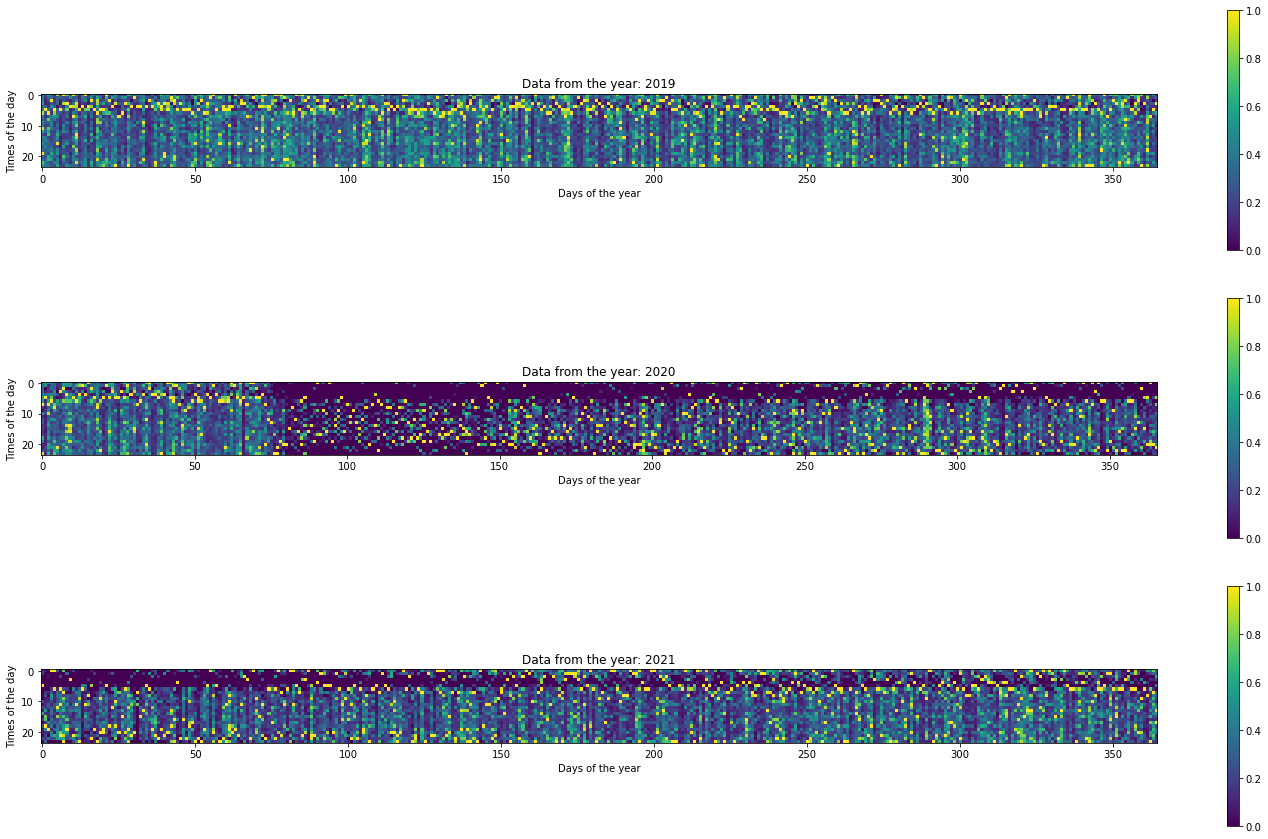

In [45]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_distance', 'Days of the year', 'Times of the day')

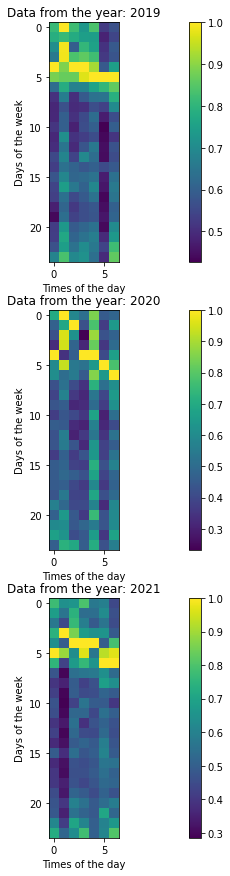

In [46]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_distance', 'Times of the day', 'Days of the week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Finally, view the average speed at different times of the day during the week.

In [47]:
def speed_heatmap(df, group, xlabel, ylabel, columns = None):
    """
    Function that aggregates data appropriately to display a speed heatmap
    """
    # We can use directly the fuction we have already create before
    
    heatmap(df,group,'trip_avg_speed',xlabel,ylabel,columns = None)
    
    return 
    # HERE YOUR CODE
    #raise NotImplementedError

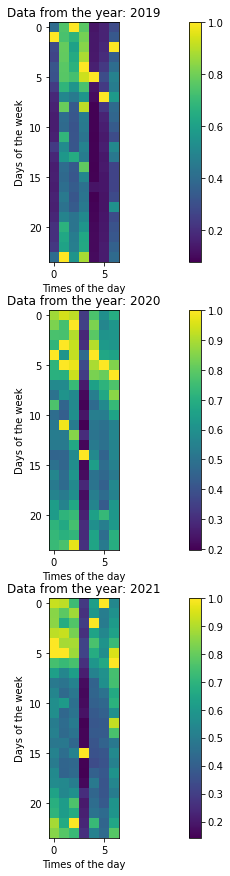

In [48]:
speed_heatmap(df, ['pickup_hour', 'pickup_day'], 'Times of the day', 'Days of the week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

**Question: Which conclusions do you obtain from the heatmaps?**
    
> ANSWER

## 05. Visualize the locations of the trips

In [49]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_week,pickup_dayofyear,dropoff_day,dropoff_month,dropoff_year,dropoff_hour,dropoff_week,dropoff_dayofyear,trip_duration,trip_avg_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.414016,151,239,1,7.0,9.95,2019,...,1,1,1,1,2019,0,1,1,0.111111,21.726144
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,3.073847,148,137,2,8.5,9.80,2019,...,1,1,1,1,2019,1,1,1,0.135278,22.722483
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,12.391949,264,264,1,26.0,31.30,2019,...,1,1,1,1,2019,1,1,1,0.489444,25.318397
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,2.253082,249,164,1,7.5,11.40,2019,...,1,1,1,1,2019,1,1,1,0.140833,15.998213
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,1.078260,162,137,2,4.0,5.30,2019,...,1,1,1,1,2019,0,1,1,0.050000,21.565210


The data only has the ID of a location, so you need to add the latitude and longitude.

This information is saved in *data/geodata/taxi_zones.shp*.

The next cells can be understood as a black box.

In [50]:
from utils import get_lat_lon, draw_region_map, draw_zone_map

In [51]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [52]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")

df_loc.head()


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664


/Users/quim/opt/anaconda3/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


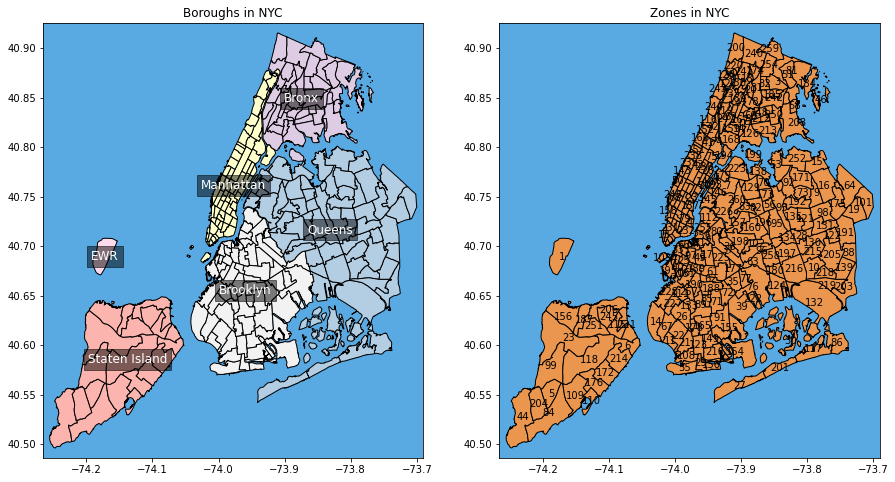

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)

ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

Now you have two dataframes that you need to join. Use the *pd.merge* function to add the longitude and latitude to the *df* dataframe:

In [54]:
merge_pu = pd.merge(df_filtered, df_loc, left_on='PULocationID', right_on='LocationID')

In [55]:
merge_pu = pd.DataFrame(merge_pu)

In [56]:
merge_pu = merge_pu.rename(columns={'OBJECTID':'PUOBJECTID',
                                    'Shape_Leng':'PUShape_Leng',
                                    'Shape_Area':'PUShape_Area',
                                    'zone':'PUzone',
                                    'LocationID': 'PULocID',
                                    'borough': 'PUborough',
                                    'longitude': 'PUlongitude',
                                    'latitude': 'PUlatitude'
                                   })

In [57]:
merge_pu.head()


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,trip_duration,trip_avg_speed,PUOBJECTID,PUShape_Leng,PUShape_Area,PUzone,PULocID,PUborough,PUlongitude,PUlatitude
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.414016,151,239,1,7.0,9.95,2019,...,0.111111,21.726144,151,0.05489,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
1,2019-01-01 01:13:52,2019-01-01 01:23:56,1.0,2.896819,151,236,2,9.0,10.30,2019,...,0.167778,17.265810,151,0.05489,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
2,2019-01-01 11:50:47,2019-01-01 11:59:38,1.0,2.832445,151,142,2,8.5,9.30,2019,...,0.147500,19.203020,151,0.05489,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
3,2019-01-01 14:39:57,2019-01-01 14:47:33,6.0,2.526670,151,41,2,8.0,8.80,2019,...,0.126667,19.947395,151,0.05489,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
4,2019-01-01 17:23:52,2019-01-01 17:28:16,1.0,1.287475,151,238,1,5.5,7.25,2019,...,0.073333,17.556480,151,0.05489,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859


In [58]:
merge_do = pd.merge(df_filtered, df_loc, left_on='DOLocationID', right_on='LocationID')

In [59]:
merge_do = pd.DataFrame(merge_do)

In [60]:
merge_do = merge_do.rename(columns={'OBJECTID':'DOOBJECTID',
                                    'Shape_Leng':'DOShape_Leng',
                                    'Shape_Area':'DOShape_Area',
                                    'zone':'DOzone',
                                    'LocationID': 'DOLocID',
                                    'borough': 'DOborough',
                                    'longitude': 'DOlongitude',
                                    'latitude': 'DOlatitude'
                                   })

In [61]:
merge_do.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,trip_duration,trip_avg_speed,DOOBJECTID,DOShape_Leng,DOShape_Area,DOzone,DOLocID,DOborough,DOlongitude,DOlatitude
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.414016,151,239,1,7.0,9.95,2019,...,0.111111,21.726144,239,0.063626,0.000205,Upper West Side South,239,Manhattan,-73.978732,40.784025
1,2019-01-01 01:38:04,2019-01-01 02:03:26,2.0,8.014533,107,239,1,19.5,23.30,2019,...,0.422778,18.956846,239,0.063626,0.000205,Upper West Side South,239,Manhattan,-73.978732,40.784025
2,2019-01-01 03:58:32,2019-01-01 04:16:09,1.0,7.917972,79,239,1,17.0,21.96,2019,...,0.293611,26.967551,239,0.063626,0.000205,Upper West Side South,239,Manhattan,-73.978732,40.784025
3,2019-01-01 15:41:46,2019-01-01 15:53:59,1.0,3.701491,162,239,2,10.5,11.30,2019,...,0.203611,18.179220,239,0.063626,0.000205,Upper West Side South,239,Manhattan,-73.978732,40.784025
4,2019-01-01 21:02:40,2019-01-01 21:05:42,1.0,0.949513,238,239,1,4.5,6.96,2019,...,0.050556,18.781575,239,0.063626,0.000205,Upper West Side South,239,Manhattan,-73.978732,40.784025


In [62]:
merge = pd.merge(merge_pu, merge_do)

In [63]:
merge = pd.DataFrame(merge)
merge.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,PUlongitude,PUlatitude,DOOBJECTID,DOShape_Leng,DOShape_Area,DOzone,DOLocID,DOborough,DOlongitude,DOlatitude
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.414016,151,239,1,7.0,9.95,2019,...,-73.968222,40.797859,239,0.063626,0.000205,Upper West Side South,239,Manhattan,-73.978732,40.784025
1,2019-01-01 01:13:52,2019-01-01 01:23:56,1.0,2.896819,151,236,2,9.0,10.30,2019,...,-73.968222,40.797859,236,0.044252,0.000103,Upper East Side North,236,Manhattan,-73.957010,40.780440
2,2019-01-01 11:50:47,2019-01-01 11:59:38,1.0,2.832445,151,142,2,8.5,9.30,2019,...,-73.968222,40.797859,142,0.038176,0.000076,Lincoln Square East,142,Manhattan,-73.981530,40.773659
3,2019-01-01 14:39:57,2019-01-01 14:47:33,6.0,2.526670,151,41,2,8.0,8.80,2019,...,-73.968222,40.797859,41,0.052793,0.000143,Central Harlem,41,Manhattan,-73.950709,40.804176
4,2019-01-01 17:23:52,2019-01-01 17:28:16,1.0,1.287475,151,238,1,5.5,7.25,2019,...,-73.968222,40.797859,238,0.060109,0.000185,Upper West Side North,238,Manhattan,-73.973031,40.791783


Text(0.5, 1.0, 'Dropoff Location')

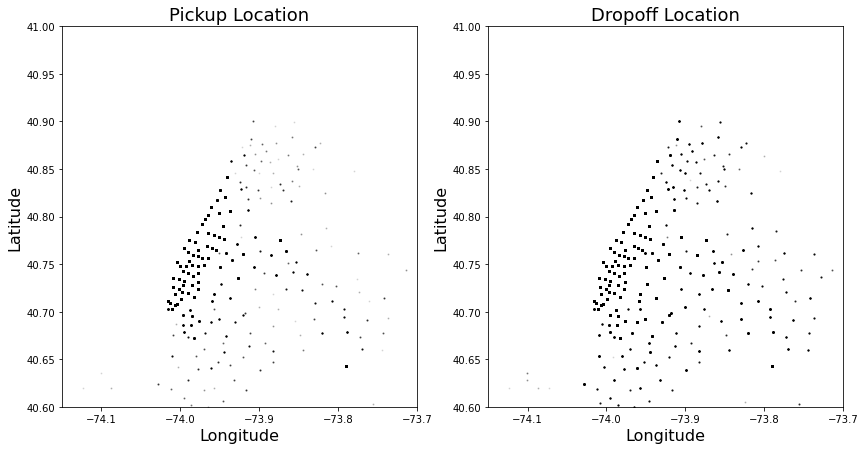

In [64]:
# Plotting PU and DO locations
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(merge.PUlongitude,
            merge.PUlatitude,
            s=1,alpha=0.1,color='black')

plt.ylim([40.60,41.00])
plt.xlim([-74.15,-73.70])
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('Pickup Location',fontsize=18)

ax1 = fig.add_subplot(122)
ax1.scatter(merge.DOlongitude,
            merge.DOlatitude,
            s=1,alpha=0.1,color='black')

plt.ylim([40.60,41.00])
plt.xlim([-74.15,-73.70])
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('Dropoff Location',fontsize=18)

Text(0.5, 1.0, 'Dropoff Location')

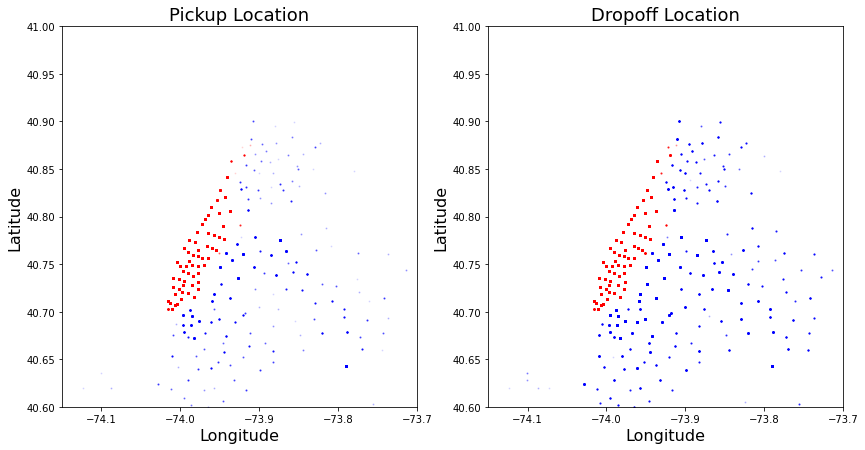

In [65]:

# Plotting Manhattan vs Non-Manhattan
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(merge.PUlongitude[merge.PUborough=='Manhattan'],
            merge.PUlatitude[merge.PUborough=='Manhattan'],
            s=1,alpha=0.1,color='red')
ax1.scatter(merge.PUlongitude[merge.PUborough!='Manhattan'],
            merge.PUlatitude[merge.PUborough!='Manhattan'],
            s=1,alpha=0.1,color='blue')

plt.ylim([40.60,41.00])
plt.xlim([-74.15,-73.70])
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('Pickup Location',fontsize=18)

ax1 = fig.add_subplot(122)
ax1.scatter(merge.DOlongitude[merge.DOborough=='Manhattan'],
            merge.DOlatitude[merge.DOborough=='Manhattan'],
            s=1,alpha=0.1,color='red')
ax1.scatter(merge.DOlongitude[merge.DOborough!='Manhattan'],
            merge.DOlatitude[merge.DOborough!='Manhattan'],
            s=1,alpha=0.1,color='blue')

plt.ylim([40.60,41.00])
plt.xlim([-74.15,-73.70])
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('Dropoff Location',fontsize=18)

Text(0.5, 1.0, 'Dropoff Location')

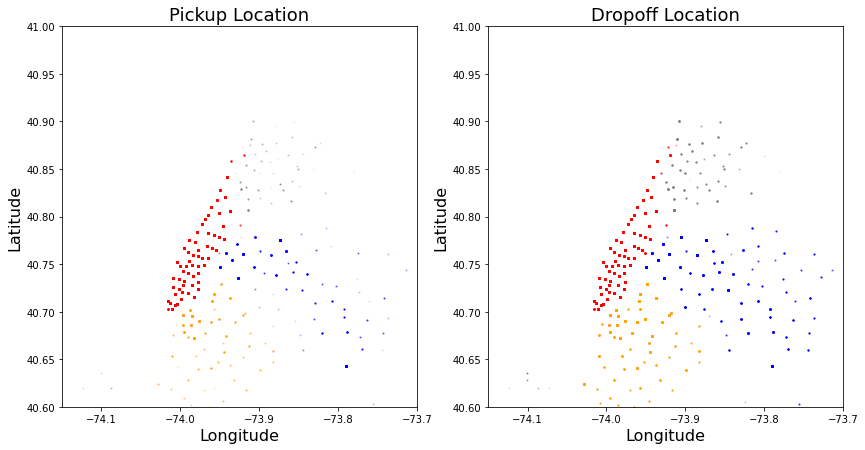

In [66]:
# Plotting by borough
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(merge.PUlongitude[merge.PUborough=='Manhattan'],
            merge.PUlatitude[merge.PUborough=='Manhattan'],
            s=1,alpha=0.1,color='red')
ax1.scatter(merge.PUlongitude[merge.PUborough=='Queens'],
            merge.PUlatitude[merge.PUborough=='Queens'],
            s=1,alpha=0.1,color='blue')
ax1.scatter(merge.PUlongitude[merge.PUborough=='Bronx'],
            merge.PUlatitude[merge.PUborough=='Bronx'],
            s=1,alpha=0.1,color='grey')
ax1.scatter(merge.PUlongitude[merge.PUborough=='Brooklyn'],
            merge.PUlatitude[merge.PUborough=='Brooklyn'],
            s=1,alpha=0.1,color='orange')
ax1.scatter(merge.PUlongitude[merge.PUborough=='EWR'],
            merge.PUlatitude[merge.PUborough=='EWR'],
            s=1,alpha=0.1,color='green')
ax1.scatter(merge.PUlongitude[merge.PUborough=='Staten Island'],
            merge.PUlatitude[merge.PUborough=='Staten Island'],
            s=1,alpha=0.1,color='black')

plt.ylim([40.60,41.00])
plt.xlim([-74.15,-73.70])
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('Pickup Location',fontsize=18)

ax1 = fig.add_subplot(122)
ax1.scatter(merge.DOlongitude[merge.DOborough=='Manhattan'],
            merge.DOlatitude[merge.DOborough=='Manhattan'],
            s=1,alpha=0.1,color='red')
ax1.scatter(merge.DOlongitude[merge.DOborough=='Queens'],
            merge.DOlatitude[merge.DOborough=='Queens'],
            s=1,alpha=0.1,color='blue')
ax1.scatter(merge.DOlongitude[merge.DOborough=='Bronx'],
            merge.DOlatitude[merge.DOborough=='Bronx'],
            s=1,alpha=0.1,color='grey')
ax1.scatter(merge.DOlongitude[merge.DOborough=='Brooklyn'],
            merge.DOlatitude[merge.DOborough=='Brooklyn'],
            s=1,alpha=0.1,color='orange')
ax1.scatter(merge.DOlongitude[merge.DOborough=='EWR'],
            merge.DOlatitude[merge.DOborough=='EWR'],
            s=1,alpha=0.1,color='green')
ax1.scatter(merge.DOlongitude[merge.DOborough=='Staten Island'],
            merge.DOlatitude[merge.DOborough=='Staten Island'],
            s=1,alpha=0.1,color='black')

plt.ylim([40.60,41.00])
plt.xlim([-74.15,-73.70])
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('Dropoff Location',fontsize=18)

## 06. Which are the areas/zones with more pick-up and drop-off?

In this section, you have to visualize the areas where taxis are most used.

The first step is to sort and save in a variable the most common places in the pick-up and drop-off.

The variables *top_pu* and *top_do* contains a dataframe with columns: 'year', 'PULocationID', and 'count'.

In [67]:
# Pick-up
# HERE YOUR CODE
top_pu = pd.DataFrame(merge.groupby(['year','PULocationID']).size().reset_index())
top_pu.columns = ['year', 'PULocationID', 'count']

# Drop-off
# HERE YOUR CODE
top_do = pd.DataFrame(merge.groupby(['year','DOLocationID']).size().reset_index())
top_do.columns = ['year', 'DOLocationID', 'count']

Print the 5 most frequent zones per year and in each case (pick-up and drop-off).

In [69]:
n_top = 5
def show_top_n(df, column, df_loc, n_top = n_top):
    
    """
    Function that print the most common zones by year
    """
    
    for year in YEARS:
        
        result = pd.merge(df, df_loc, left_on = column , right_on = 'LocationID')
        result = pd.DataFrame(result)
        sorted_df = result[result['year'] == year].sort_values(by = [column], ascending = True)
        print("Top zones the year "+ str(year))
        print(sorted_df.zone[:n_top])
    return
    # HERE YOUR CODE
    #raise NotImplementedError

In [70]:
show_top_n(top_pu, 'PULocationID', df_loc)

Top zones the year 2019
0             Newark Airport
3    Allerton/Pelham Gardens
4              Alphabet City
7              Arden Heights
8                    Astoria
Name: zone, dtype: object
Top zones the year 2020
1     Newark Airport
5      Alphabet City
9            Astoria
13      Baisley Park
16      Battery Park
Name: zone, dtype: object
Top zones the year 2021
2     Newark Airport
6      Alphabet City
10           Astoria
14      Baisley Park
17      Battery Park
Name: zone, dtype: object


In [71]:
show_top_n(top_do, 'DOLocationID', df_loc)

Top zones the year 2019
0              Newark Airport
3     Allerton/Pelham Gardens
6               Alphabet City
9                     Astoria
12               Astoria Park
Name: zone, dtype: object
Top zones the year 2020
1               Newark Airport
4      Allerton/Pelham Gardens
7                Alphabet City
716              Arden Heights
10                     Astoria
Name: zone, dtype: object
Top zones the year 2021
2               Newark Airport
5      Allerton/Pelham Gardens
8                Alphabet City
717              Arden Heights
11                     Astoria
Name: zone, dtype: object


**Let's see with a heat map which are the most common zones**

/Users/quim/opt/anaconda3/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Users/quim/opt/anaconda3/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Users/quim/opt/anaconda3/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


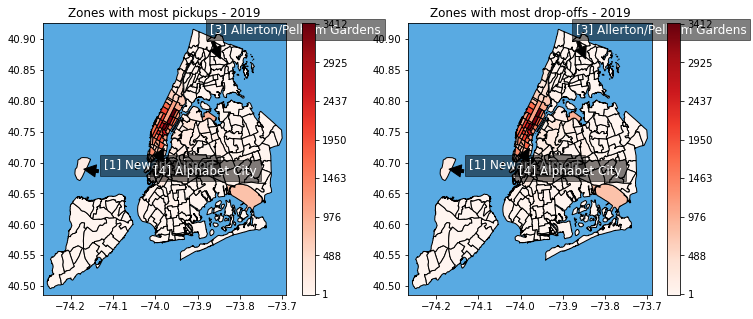

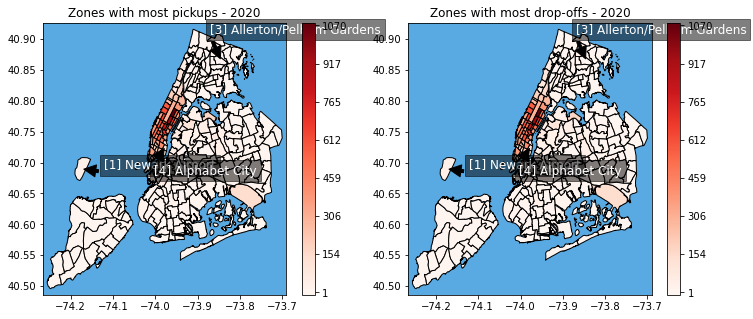

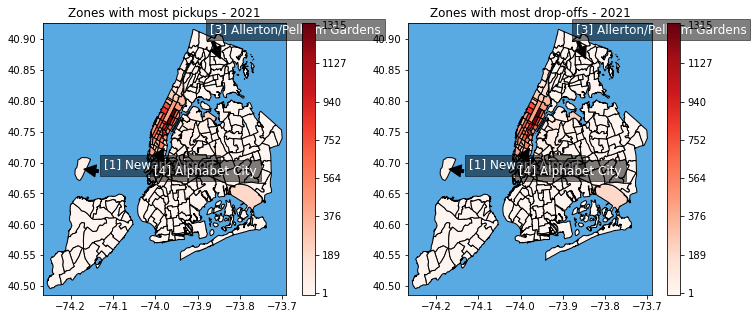

In [72]:
for year in YEARS:
    
    PUcount = {k:v for k, v in top_do[top_do.year == year][['DOLocationID', 'count']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

**Question: Why do you think the Manhattan area has more trips?**

> ANSWER

## 07. Hospitals

How has the travel destination changed? Are more people going to hospitals?

In the next cell, there is a DataFrame with the most important hospitals in New York and their locations.

In [73]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()

,Place Name,Latitude,Longitude
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077


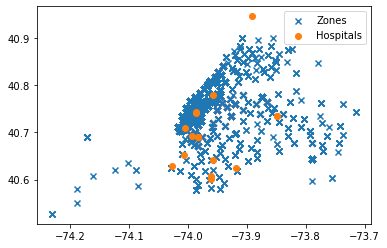

In [89]:
plt.scatter(merge.PUlongitude, merge.PUlatitude,marker = 'x')
plt.scatter(hospitals.Longitude,hospitals.Latitude)
plt.legend(['Zones', 'Hospitals'])
plt.show()

Use the latitude and longitude of each hospital and the latitude and longitude of the zone (information in *merge* dataframe) to see the distribution of the hospitals "on the map".

To do this, use a scatter plot. It will be better understood if the points are transparent (parameter *alpha*).

Also, remember how the longitude and latitude data have to be plotted in the figure.

Then repeat the same scatter plot but separated by years.

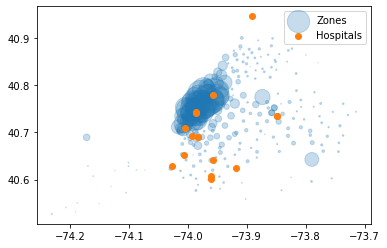

In [110]:
# We get the counts by destination
dropoff_count = pd.DataFrame(merge.groupby(['DOLocationID']).size().reset_index())
dropoff_count.columns = ['DOLocationID', 'count']
# We add the information from the count to a new df_loc data frame
test = pd.DataFrame(pd.merge(df_loc,dropoff_count,left_on = 'LocationID', right_on = 'DOLocationID'))
N=1000
size = N*test['count']/max(test['count'])
plt.scatter(test.longitude, test.latitude, s = size, alpha = 0.25)
plt.scatter(hospitals.Longitude,hospitals.Latitude)
plt.legend(['Zones', 'Hospitals'])

In [115]:
def scatter_locations(merge, hospitals):
    """Function showing the distribution of hospitals and taxi destinations"""
    
    # We get the counts by destination
    dropoff_count = pd.DataFrame(merge.groupby(['DOLocationID']).size().reset_index())
    dropoff_count.columns = ['DOLocationID', 'count']
    
    # We add the information from the count to a new df_loc data frame
    count_by_location = pd.DataFrame(pd.merge(df_loc,dropoff_count,left_on = 'LocationID', right_on = 'DOLocationID'))
    
    # We prepare the scatter plot
    N=1000
    size = N*count_by_location['count']/max(count_by_location['count'])
    plt.scatter(count_by_location.longitude, count_by_location.latitude, s = size, alpha = 0.25)
    plt.scatter(hospitals.Longitude,hospitals.Latitude)
    plt.legend(['Zones', 'Hospitals'])
    plt(show)
    return
    # HERE YOUR CODE
    #raise NotImplementedError

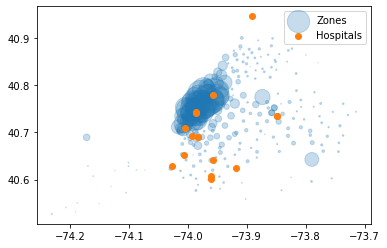

In [116]:
scatter_locations(merge, hospitals)

In [119]:
def scatter_locations_per_year(merge, hospitals):
    """Function showing the distribution of hospitals and taxi destinations per year"""
    
    plt.figure(figsize = (25,15))
    n = 311
    for year in YEARS:
        merge_y = merge[merge['year']==year]
        # We get the counts by destination
        dropoff_count = pd.DataFrame(merge_y.groupby(['DOLocationID']).size().reset_index())
        dropoff_count.columns = ['DOLocationID', 'count']

        # We add the information from the count to a new df_loc data frame
        count_by_location = pd.DataFrame(pd.merge(df_loc,dropoff_count,left_on = 'LocationID', right_on = 'DOLocationID'))

        # We prepare the scatter plot
        N=1000
        size = N*count_by_location['count']/max(count_by_location['count'])
        
        plt.subplot(n)
        plt.scatter(count_by_location.longitude, count_by_location.latitude, s = size, alpha = 0.25)
        plt.scatter(hospitals.Longitude,hospitals.Latitude)
        plt.title('Dropoff by zones and Hospitals display. Year ('+ str(year)+ ')')
        plt.legend(['Zones', 'Hospitals'])
        n=n+1
    
    plt.show()
    return
    # HERE YOUR CODE
    #raise NotImplementedError

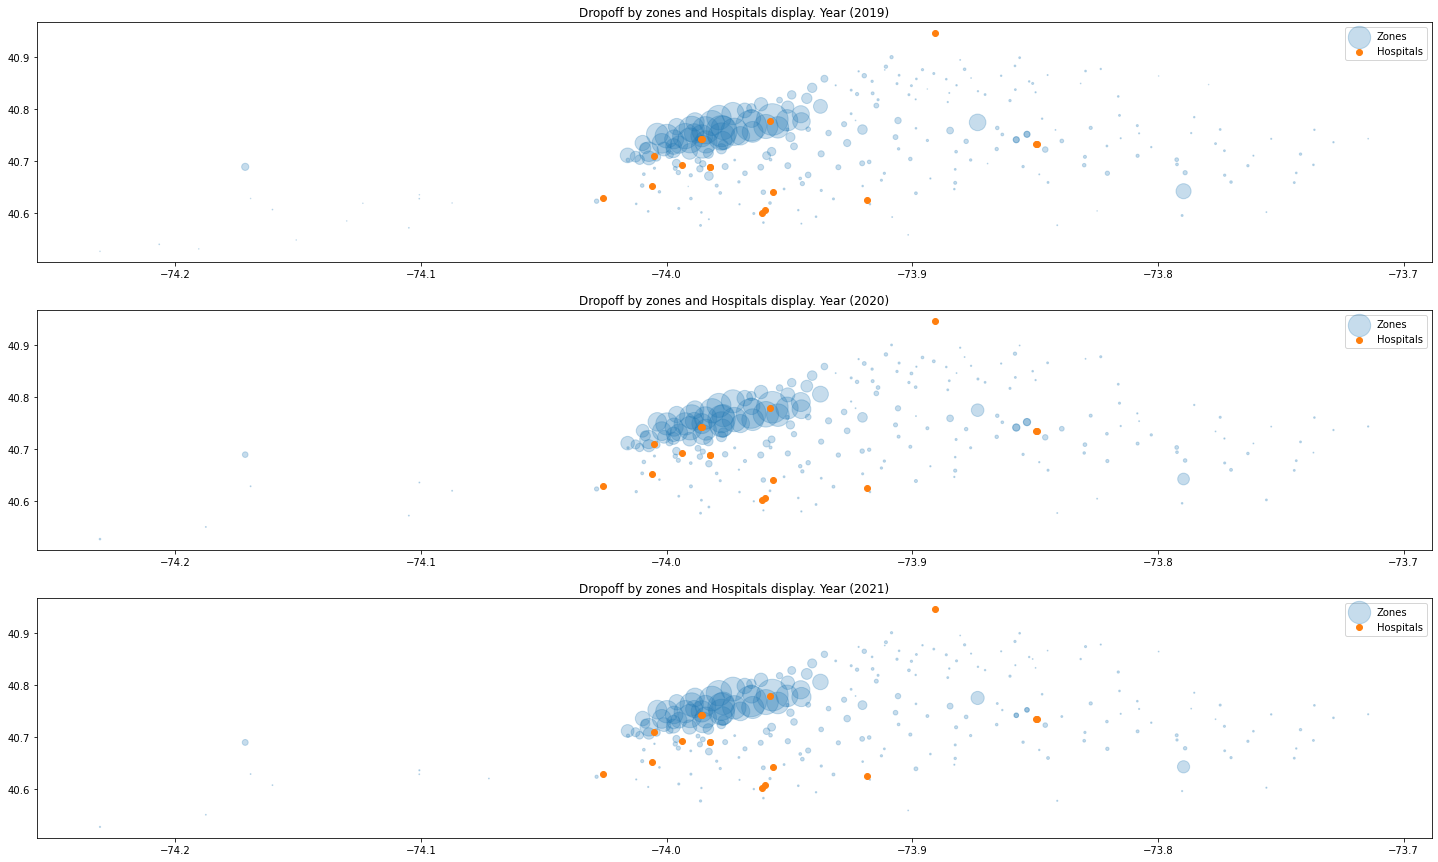

In [120]:
scatter_locations_per_year(merge, hospitals)

**Question: Do you see any behavior?**

>ANSWER

Only with this charts we aren't able to take any descision. The thing that is clear is that most of the taxis droppoff are in the manhattan borough.

To find out how trips to hospitals have changed, you need to detect in which zone is each hospital.

To do it, you need to calculate the distances between the hospitals and the zones. 

Do not calculate the distance point-to-point, but matrix-wise.

In [80]:
from scipy.spatial import distance_matrix

In [122]:
hospitals_loc = hospitals[['Longitude', 'Latitude']].values
loc = df_loc[['longitude', 'latitude']].values

# HERE YOUR CODE
dist = distance_matrix(hospitals_loc,loc)

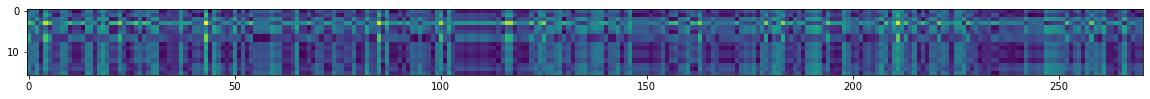

In [123]:
# Distances as an image
plt.figure(figsize=(20, 5))
plt.imshow(dist)

In [127]:
merge.shape[0]

132965

Find a way to locate the nearest sector based on distances.

In [124]:
# HERE YOUR CODE
hospitals_locations = dist.argmin(1)
hospitals['LocationID'] = hospitals_locations

In [84]:
hospitals.head()

,Place Name,Latitude,Longitude,LocationID
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058,216
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092,243
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067,130
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671,207
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077,13


Now that you know the zone of each hospital, visualize how many trips are related to them.

You will assume that all trips in the zone go to the hospital.

Make a single figure with two bar plots showing the number of trips for each year and the % of total trips.

In [ ]:
def trips_hospitals(df, hospitals_locations):
    """
    Function that displays a single figure with two bar plots showing the number of trips for each year and the % of total trips.
    """
    plt.figure(figsize = (25,15))
    n = 311
    for year in YEARS:
        merge_y = merge[merge['year']==year]
        # We determine the number of trips for a giving year
        total_trips_y = merge_y.shape[0]
        
        merge_y_hospitals = pd.DataFrame(pd.merge(merge_y, hospital_locations, left_on = 'DOLocationID'))
        # We get the counts by destination
        dropoff_count = pd.DataFrame(merge_y.groupby(['DOLocationID']).size().reset_index())
        dropoff_count.columns = ['DOLocationID', 'count']

        # We add the information from the count to a new df_loc data frame
        count_by_location = pd.DataFrame(pd.merge(df_loc,dropoff_count,left_on = 'LocationID', right_on = 'DOLocationID'))

        # We prepare the scatter plot
        N=1000
        size = N*count_by_location['count']/max(count_by_location['count'])
        
        plt.subplot(n)
        plt.scatter(count_by_location.longitude, count_by_location.latitude, s = size, alpha = 0.25)
        plt.scatter(hospitals.Longitude,hospitals.Latitude)
        plt.title('Dropoff by zones and Hospitals display. Year ('+ str(year)+ ')')
        plt.legend(['Zones', 'Hospitals'])
        n=n+1
    
    plt.show()
    return
    # HERE YOUR CODE
    #raise NotImplementedError

In [ ]:
trips_hospitals(df, hospitals_locations)

## 08. Curiosity killed the cat

In the **first part** you must view and comment on the examples you have removed, such as very long distances, very short distances...

In the **second part** you are free to choose and make visualizations that bring you extra information that has not been seen before.

## 09. Report

Based on the data exploration you have done throughout this notebook, make a short report summarizing and justifying all the changes that have arisen due to covid.